In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import os
import json
from glob import glob
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline

# 분류기 임포트
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import sklearn
import joblib
from pycaret.classification import *
from skimage.transform import radon
plt.style.use('default') 


In [2]:
df=pd.read_pickle("./LSWMD.pkl")

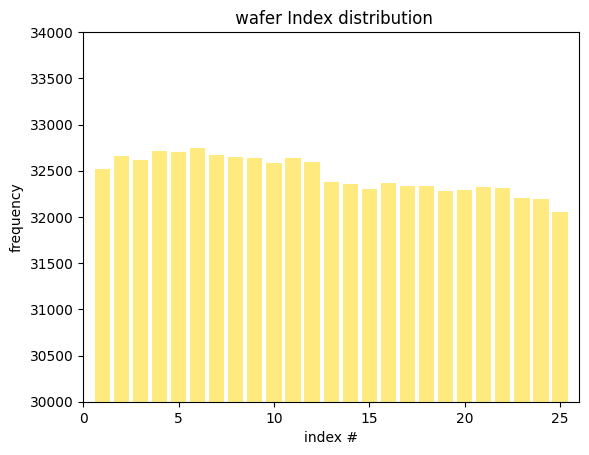

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline


uni_Index=np.unique(df.waferIndex, return_counts=True)
plt.bar(uni_Index[0],uni_Index[1], color='gold', align='center', alpha=0.5)
plt.title(" wafer Index distribution")
plt.xlabel("index #")
plt.ylabel("frequency")
plt.xlim(0,26)
plt.ylim(30000,34000)
plt.show()

In [4]:
df=df.drop(['waferIndex'], axis=1)

In [5]:
def find_dim(x):                # 'waferMap' 값을 받아 
    dim0=np.size(x, axis=0)
    dim1=np.size(x, axis=1)
    return dim0, dim1

df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
93089,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,...",682.0,lot6599,[],[],"(31, 28)"
727611,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",776.0,lot44136,[[Test]],[[none]],"(30, 34)"
41339,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1,...",736.0,lot3632,[],[],"(31, 31)"
174415,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",6065.0,lot11153,[],[],"(87, 89)"
415697,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2367.0,lot24704,[],[],"(51, 59)"


In [6]:
max(df.waferMapDim), min(df.waferMapDim)

((300, 202), (6, 21))

In [7]:
uni_waferDim=np.unique(df.waferMapDim, return_counts=True)
uni_waferDim[0].shape[0]

632

In [8]:
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel

In [9]:
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel
mapping_type={'Center':0, 'Donut':1, 'Edge-Loc':2, 'Edge-Ring':3, 'Loc':4, 'Random':5,'Scratch':6, 'Near-full':7, 'none':8}
mapping_traintest={'Training':0, 'Test':1}


df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})


In [10]:
tol_wafers=df.shape[0] # 행 갯수 반환

tol_wafers

811457

In [11]:
# 라벨이 있는 df (failureType 전부)
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]        # 새로운 데이터 프레임 생성
df_withlabel = df_withlabel.reset_index()                               # 앞에서 생성한 데이터 프레임의 인덱스 재설정

# 패턴이 있는 df (failureType이 none인 경우는 제외)
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]      # 새로운 데이터 프레임 생성
df_withpattern = df_withpattern.reset_index()                           # 데이터 프레임 인덱스 재설정

# 패턴이 없는 df (failureType이 none인 경우)
df_nonpattern = df[(df['failureNum']==8)]                               # 새로운 데이터 프레임 생성

df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]  # 각 데이터 프레임 행 갯수 반환

(172950, 25519, 147431)

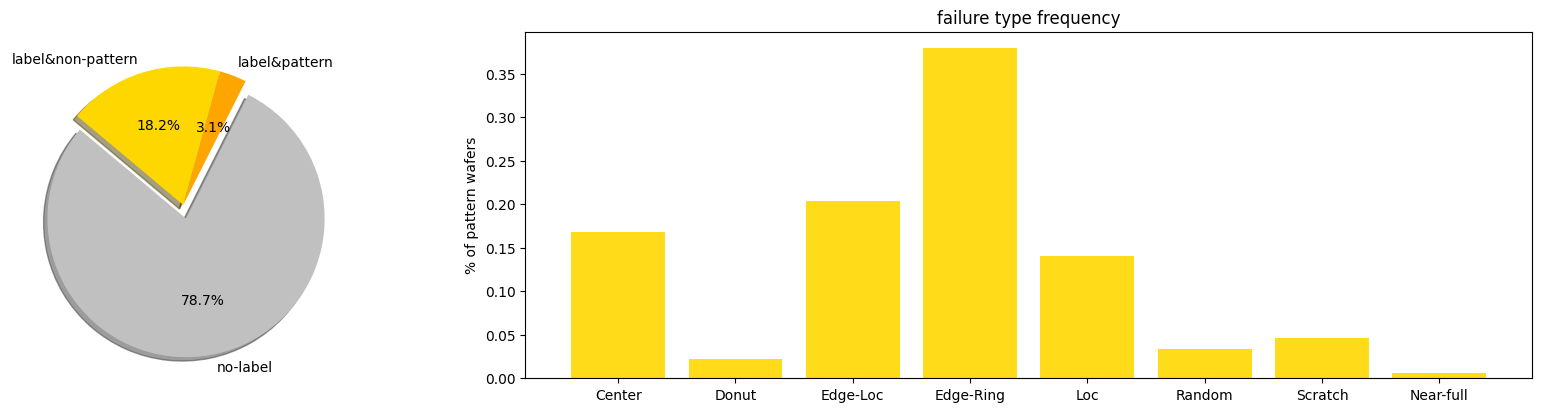

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import gridspec
fig = plt.figure(figsize=(20, 4.5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2.5]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])


no_wafers=[tol_wafers - df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]]

colors = ['silver', 'orange', 'gold']
explode = (0.1, 0, 0)  # explode 1st slice
labels = ['no-label','label&pattern','label&non-pattern']
ax1.pie(no_wafers, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

uni_pattern=np.unique(df_withpattern.failureNum, return_counts=True)
labels2 = ['','Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
ax2.bar(uni_pattern[0],uni_pattern[1]/df_withpattern.shape[0], color='gold', align='center', alpha=0.9)
ax2.set_title("failure type frequency")
ax2.set_ylabel("% of pattern wafers")
ax2.set_xticklabels(labels2)

plt.show()

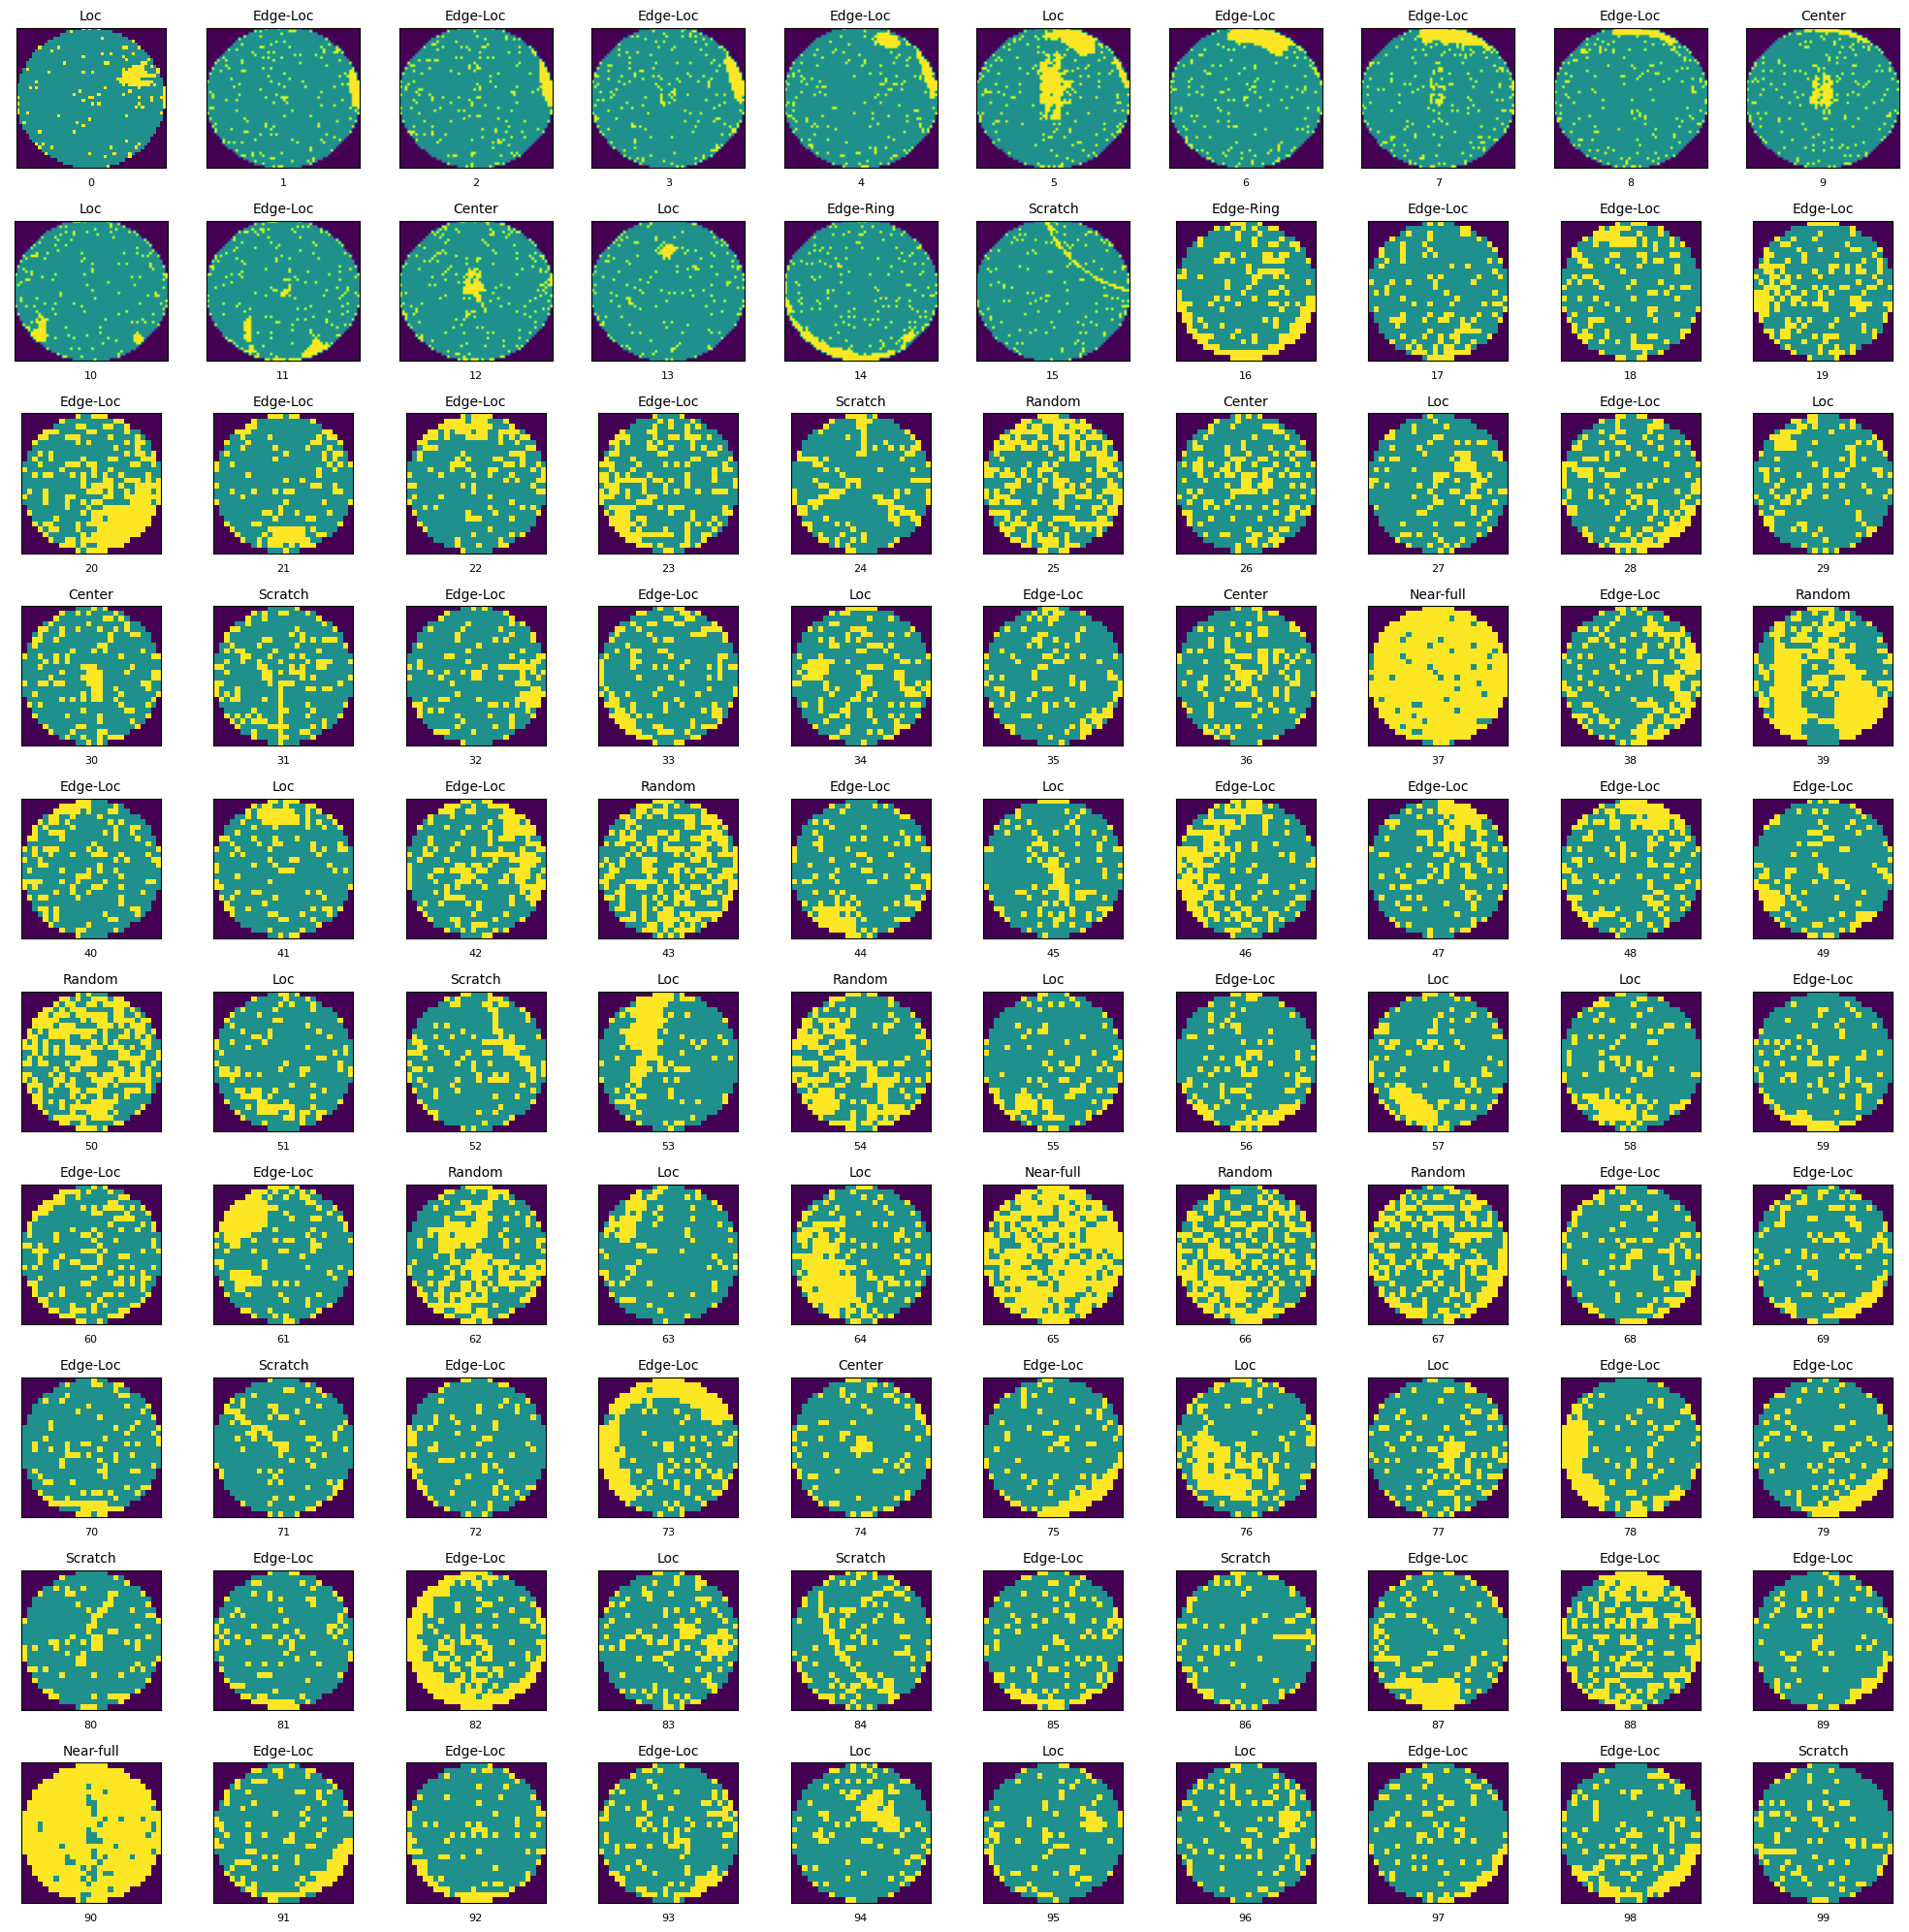

In [13]:
plt.style.use('default') 
fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(20, 20))
ax = ax.ravel(order='C')

for i in range(100):
    img = df_withpattern.waferMap[i]
    ax[i].imshow(img)

    # 블로그 원본 방식 (중첩 리스트 구조 가정)
    ax[i].set_title(df_withpattern.failureType[i][0][0], fontsize=10)

    ax[i].set_xlabel(df_withpattern.index[i], fontsize=8)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.tight_layout()
plt.show()


In [14]:
from matplotlib import gridspec

In [15]:
df_withpattern

,index,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim,failureNum,trainTestNum
0,19,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[Loc]],"(45, 48)",4,0
1,36,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,[[Training]],[[Edge-Loc]],"(53, 58)",2,0
2,37,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,[[Training]],[[Edge-Loc]],"(53, 58)",2,0
3,38,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,[[Training]],[[Edge-Loc]],"(53, 58)",2,0
4,39,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,[[Training]],[[Edge-Loc]],"(53, 58)",2,0
...,...,...,...,...,...,...,...,...,...
25514,811450,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",600.0,lot47542,[[Test]],[[Edge-Loc]],"(26, 30)",2,1
25515,811451,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,[[Test]],[[Edge-Loc]],"(26, 30)",2,1
25516,811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,[[Test]],[[Edge-Ring]],"(26, 30)",3,1
25517,811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,[[Test]],[[Edge-Loc]],"(26, 30)",2,1


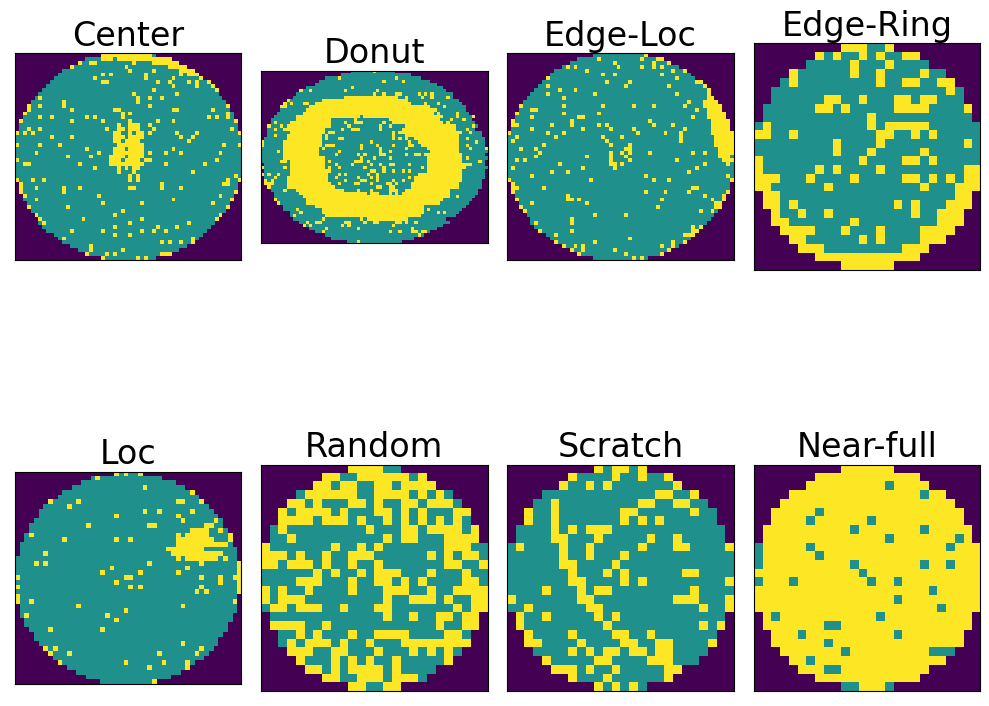

In [16]:
plt.style.use('default') 
x = [9, 340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc',
           'Random', 'Scratch', 'Near-full']
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(10, 10))
ax = ax.ravel(order='C')

for i in range(8):
     # 해당 failure type의 대표 index
    
    img = df_withpattern.waferMap[x[i]]          # wafer map 이미지
    ax[i].imshow(img)
    
    
    
    ax[i].set_title(df_withpattern.failureType[x[i]][0][0], fontsize=24)
    
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.tight_layout()
plt.show()


In [17]:
import skimage
from skimage import measure
from skimage.transform import radon
from skimage.transform import probabilistic_hough_line
from skimage import measure
from scipy import interpolate
from scipy import stats

In [18]:
def cal_den(x):
    return 100*(np.sum(x==2)/np.size(x))  

# 13개의 영역에 밀도를 계산해서 
def find_regions(x):
    rows=np.size(x,axis=0)
    cols=np.size(x,axis=1)
    ind1=np.arange(0,rows,rows//5)
    ind2=np.arange(0,cols,cols//5)

    reg1=x[ind1[0]:ind1[1],:]
    reg3=x[ind1[4]:,:]
    reg4=x[:,ind2[0]:ind2[1]]
    reg2=x[:,ind2[4]:]

    reg5=x[ind1[1]:ind1[2],ind2[1]:ind2[2]]
    reg6=x[ind1[1]:ind1[2],ind2[2]:ind2[3]]
    reg7=x[ind1[1]:ind1[2],ind2[3]:ind2[4]]
    reg8=x[ind1[2]:ind1[3],ind2[1]:ind2[2]]
    reg9=x[ind1[2]:ind1[3],ind2[2]:ind2[3]]
    reg10=x[ind1[2]:ind1[3],ind2[3]:ind2[4]]
    reg11=x[ind1[3]:ind1[4],ind2[1]:ind2[2]]
    reg12=x[ind1[3]:ind1[4],ind2[2]:ind2[3]]
    reg13=x[ind1[3]:ind1[4],ind2[3]:ind2[4]]

    fea_reg_den = []
    fea_reg_den = [cal_den(reg1),cal_den(reg2),cal_den(reg3),cal_den(reg4),cal_den(reg5),cal_den(reg6),cal_den(reg7),cal_den(reg8),cal_den(reg9),cal_den(reg10),cal_den(reg11),cal_den(reg12),cal_den(reg13)]
    return fea_reg_den

In [19]:
df_withpattern['fea_reg']=df_withpattern.waferMap.apply(find_regions)

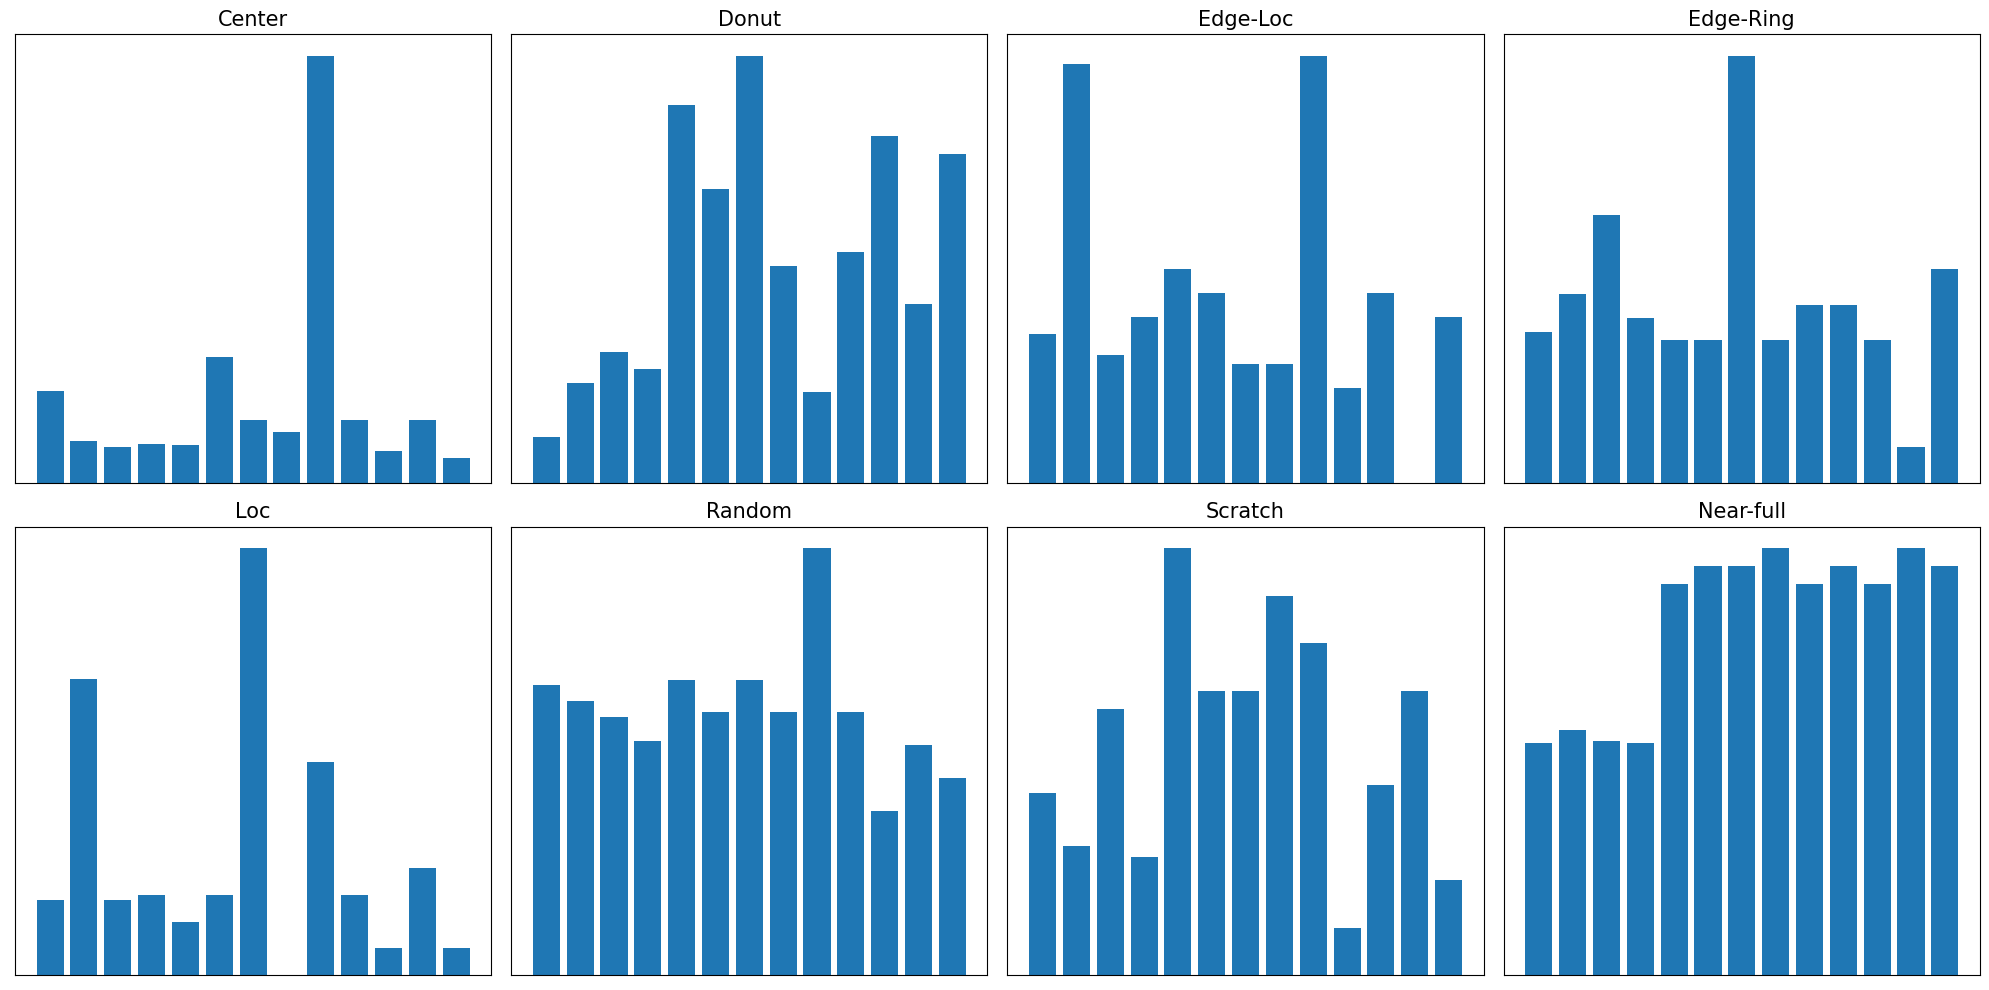

In [20]:
plt.style.use('default') 
x = [9, 340, 3, 16, 0, 25, 84, 37]      # 이 웨이퍼를 확인 
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

fig, ax = plt.subplots(nrows = 2, ncols = 4,figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    ax[i].bar(np.linspace(1,13,13),df_withpattern.fea_reg[x[i]])
    ax[i].set_title(df_withpattern.failureType[x[i]][0][0],fontsize=15)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.tight_layout()
plt.show() 

In [21]:
df.head()

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim,failureNum,trainTestNum
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8,0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8,0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8,0
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8,0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8,0


In [22]:
def change_val(img):
    img[img==1] = 0
    return img
df_withpattern_copy = df_withpattern.copy()
df_withpattern_copy['new_waferMap']=df_withpattern.waferMap.apply(change_val)
    

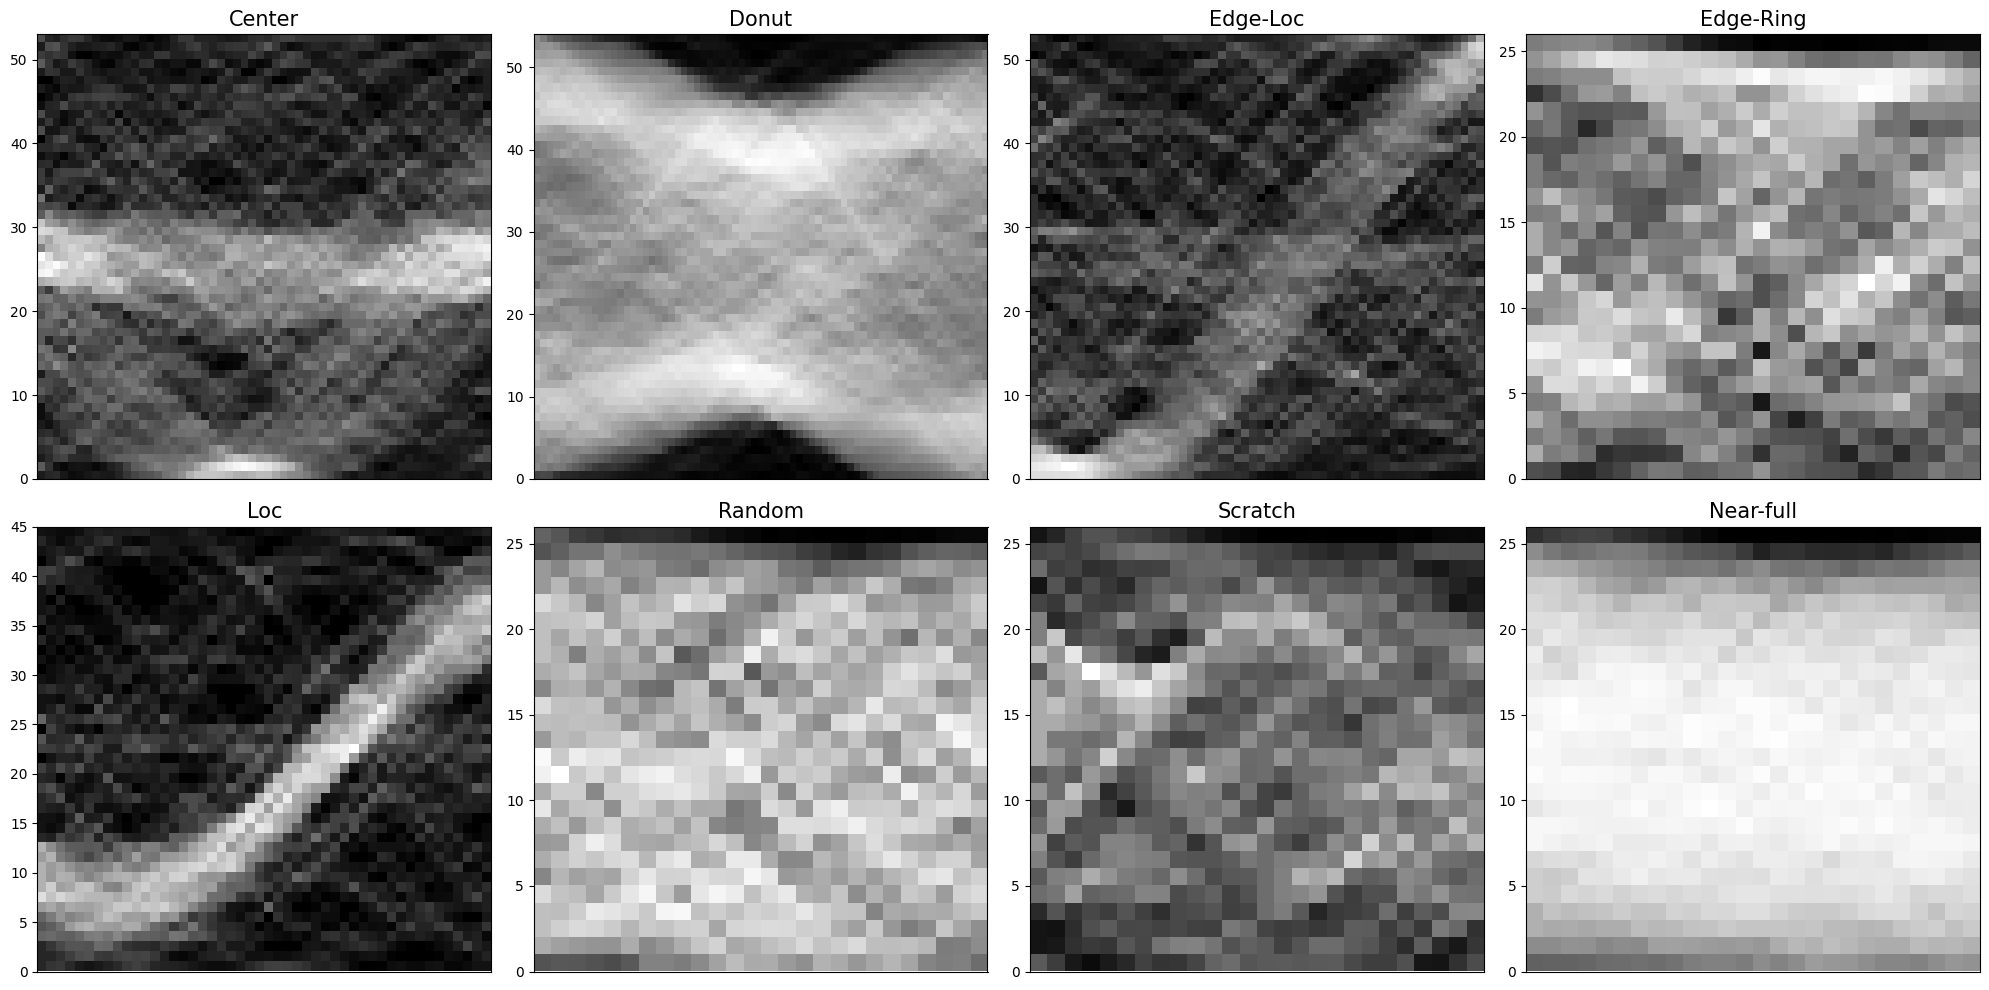

In [23]:
x = [9, 340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    img = df_withpattern_copy.waferMap[x[i]]
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta)    

    ax[i].imshow(sinogram, cmap=plt.cm.Greys_r, extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')
    ax[i].set_title(df_withpattern_copy.failureType[x[i]][0][0],fontsize=15)
    ax[i].set_xticks([])
plt.tight_layout()

plt.show() 

In [24]:
def cubic_inter_mean(img):
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta)  
    xMean_Row = np.mean(sinogram, axis = 1)                                 # 각 행에 대해 평균값을 계산 : 이 값은 모든 투영 각도에 대해 평균화된 값을 의미
    x = np.linspace(1, xMean_Row.size, xMean_Row.size)
    y = xMean_Row
    f = interpolate.interp1d(x, y, kind = 'cubic')                          # xMean_Row에 대한 보간을 수행하기 위해 3차 함수 보간법(큐빅 보간법)을 사용
    xnew = np.linspace(1, xMean_Row.size, 20)                               # 20개의 점으로 균등하게 나누어 생성
    ynew = f(xnew)/100                                                      # use interpolation function returned by `interp1d`
    return ynew                                                             # img에 대한 Radon 변환 후, 큐빅 보간법을 사용하여 얻은 평균 투영 데이터의 20개의 보간된 값

# 라돈 변환에서 각 행 표준편차 투영 데이터에서 20개의 차원으로 보간된 값 추출 


In [25]:
def cubic_inter_std(img):
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta)
    xStd_Row = np.std(sinogram, axis=1)
    x = np.linspace(1, xStd_Row.size, xStd_Row.size)
    y = xStd_Row
    f = interpolate.interp1d(x, y, kind = 'cubic')
    xnew = np.linspace(1, xStd_Row.size, 20)
    ynew = f(xnew)/100   # use interpolation function returned by `interp1d`
    return ynew 

In [26]:
df_withpattern_copy['fea_cub_mean'] = df_withpattern_copy.waferMap.apply(cubic_inter_mean)
df_withpattern_copy['fea_cub_std'] = df_withpattern_copy.waferMap.apply(cubic_inter_std)

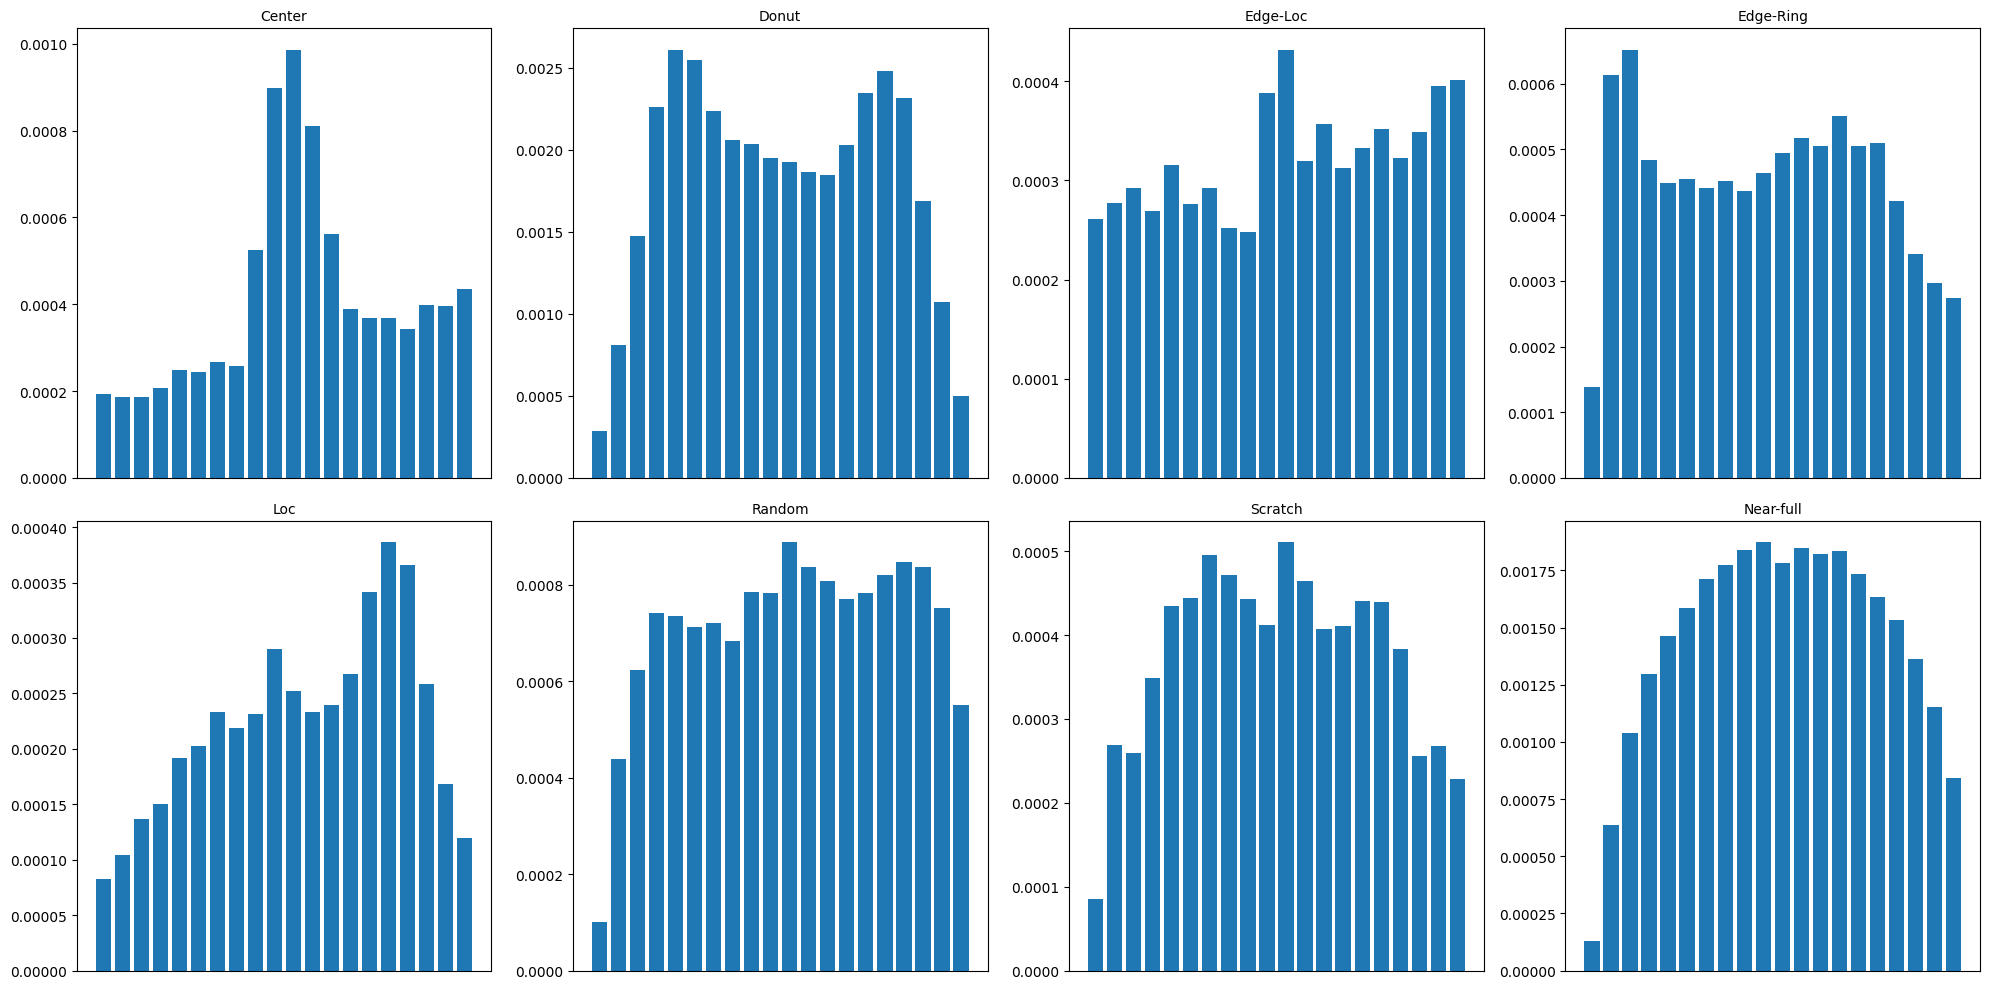

In [27]:
x = [9, 340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

fig, ax = plt.subplots(nrows = 2, ncols = 4,figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    ax[i].bar(np.linspace(1,20,20),df_withpattern_copy.fea_cub_mean[x[i]])
    ax[i].set_title(df_withpattern_copy.failureType[x[i]][0][0],fontsize=10)
    ax[i].set_xticks([])
    # ax[i].set_xlim([0,21])   
    # ax[i].set_ylim([0,1])
plt.tight_layout()
plt.show() 

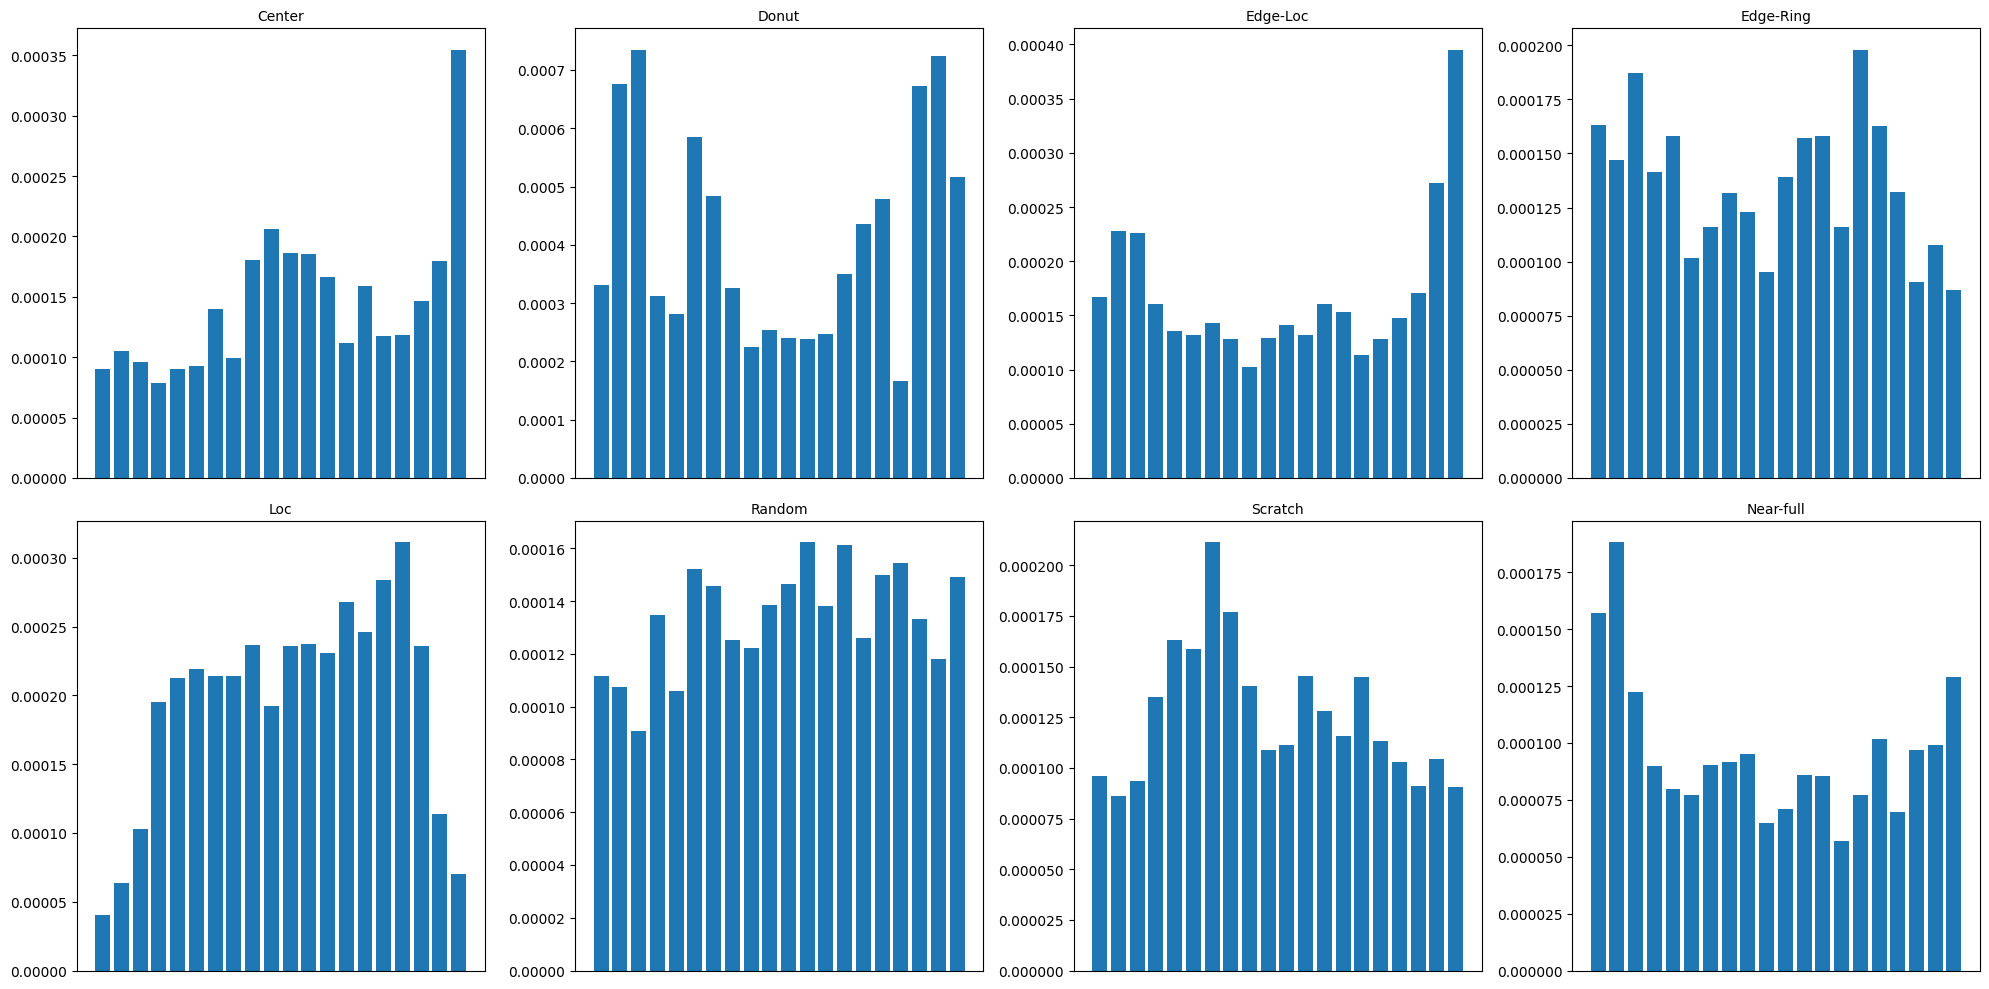

In [28]:
fig, ax = plt.subplots(nrows = 2, ncols = 4,figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    ax[i].bar(np.linspace(1,20,20),df_withpattern_copy.fea_cub_std[x[i]])
    ax[i].set_title(df_withpattern_copy.failureType[x[i]][0][0],fontsize=10)
    ax[i].set_xticks([])
    # ax[i].set_xlim([0,21])   
    # ax[i].set_ylim([0,0.3])
plt.tight_layout()
plt.show() 

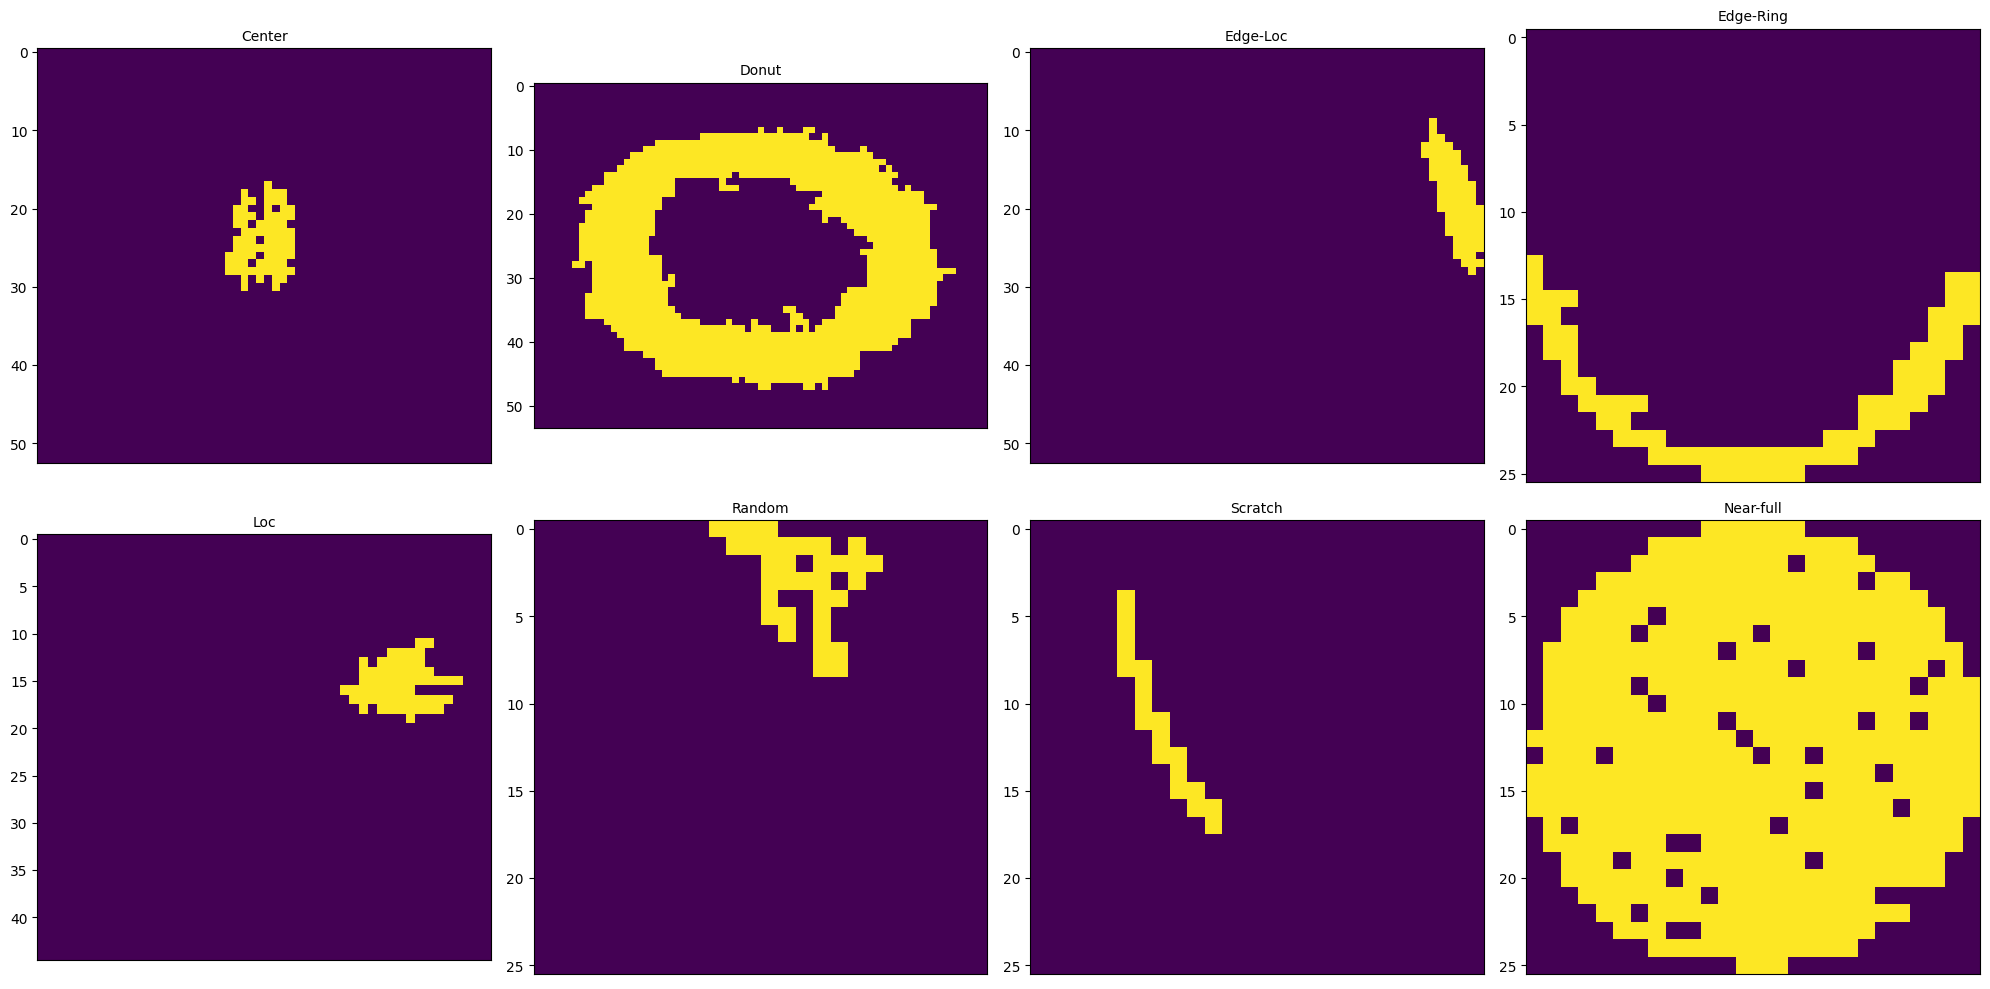

In [29]:
from skimage import measure
from scipy import stats
plt.style.use('default') 
x = [9, 340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

fig, ax = plt.subplots(nrows = 2, ncols = 4,figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    img = df_withpattern_copy.waferMap[x[i]]
    zero_img = np.zeros(img.shape)                                                  # img 크기의 빈 이미지 만들기 
    # 두 픽셀은 이웃이고 같은 값을 가질 때 연결 : 노이즈를 제거하고 각 fail type 별 웨이퍼의 불량을 뚜렷이 두드러지게 보기 위해 
    img_labels = measure.label(img, connectivity=1, background=0)                   

    img_labels = img_labels-1
    # 최빈값(대표 영역) 계산
    if img_labels.max()==0:     # img_labels에서 최댓값이 0이면, no_region을 0으로 설정
        no_region = 0
    else:
        info_region = stats.mode(img_labels[img_labels>-1], axis = None)        # 0 이상의 img_labels에서 최빈값을 찾아
        no_region = info_region[0]                                              # no_region에 할당
    # 대표 영역 강조:
    zero_img[np.where(img_labels==no_region)] = 2   # zero_img에서 no_region에 해당하는 위치를 2로 설정하여 해당 영역을 강조
    ax[i].imshow(zero_img)
    ax[i].set_title(df_withpattern_copy.failureType[x[i]][0][0],fontsize=10)
    ax[i].set_xticks([])
plt.tight_layout()
plt.show() 

In [30]:
# 특정 좌표 x,y 와 이미지 중심까지 거리 계산 -> 이미지에서 특정 지점이 중심으로부터 얼마나 떨어져 있는지를 측정
def cal_dist(img,x,y):
    dim0=np.size(img,axis=0)    
    dim1=np.size(img,axis=1)
    dist = np.sqrt((x-dim0/2)**2+(y-dim1/2)**2)
    return dist  

In [31]:
def fea_geom(img):
    norm_area=img.shape[0]*img.shape[1]                                     # 이미지의 총 픽셀 수(면적)를 계산
    norm_perimeter=np.sqrt((img.shape[0])**2+(img.shape[1])**2)             # 이미지의 대각선 길이(정규화된 둘레)를 계산

    img_labels = measure.label(img, connectivity=1, background=0)           # 이미지의 연결된 구성 요소(connected components)를 식별하고, 각 구성 요소에 고유한 레이블을 부여

    # 레이블의 가장 큰 영역 뽑기 
    if img_labels.max()==0:
        img_labels[img_labels==0]=1
        no_region = 0
    else:
        info_region = stats.mode(img_labels[img_labels>0], axis = None)
        no_region = info_region[0][0]-1       

    # 영역의 기하학적 속성 계산
    prop = measure.regionprops(img_labels)              
    prop_area = prop[no_region].area/norm_area                      # 선택된 영역의 면적을 정규화된 전체 면적으로 나눈 값
    prop_perimeter = prop[no_region].perimeter/norm_perimeter       # 선택된 영역의 둘레를 정규화된 둘레로 나눈 값

    prop_cent = prop[no_region].local_centroid                      # 선택된 영역의 무게 중심 좌표
    prop_cent = cal_dist(img,prop_cent[0],prop_cent[1])             # 이미지 중심으로부터의 거리를 계산하여 반환

    prop_majaxis = prop[no_region].major_axis_length/norm_perimeter # 선택된 영역의 주축 길이를 정규화된 둘레로 나눈 값.
    prop_minaxis = prop[no_region].minor_axis_length/norm_perimeter # 선택된 영역의 부축 길이를 정규화된 둘레로 나눈 값
    prop_ecc = prop[no_region].eccentricity                         # 선택된 영역의 이심률(0은 원에 가까운 형태, 1에 가까울수록 길쭉한 타원에 가까움).
    prop_solidity = prop[no_region].solidity                        # 선택된 영역의 밀집도(영역 면적을 볼록 껍질(convex hull) 면적으로 나눈 값).

    return prop_area,prop_perimeter,prop_majaxis,prop_minaxis,prop_ecc,prop_solidity
# 함수는 이미지의 연결된 영역을 분석하여 면적, 둘레, 중심점, 주축 및 부축 길이, 이심률, 그리고 밀집도를 계산

In [32]:
# 기하학적 특징들 추가 
df_withpattern_copy['fea_geom'] =df_withpattern_copy.waferMap.apply(fea_geom)

In [33]:
df_all=df_withpattern_copy.copy()
a=[df_all.fea_reg[i] for i in range(df_all.shape[0])] #13
b=[df_all.fea_cub_mean[i] for i in range(df_all.shape[0])] #20
c=[df_all.fea_cub_std[i] for i in range(df_all.shape[0])] #20
d=[df_all.fea_geom[i] for i in range(df_all.shape[0])] #6
fea_all = np.concatenate((np.array(a),np.array(b),np.array(c),np.array(d)),axis=1) #59 in total

In [34]:
label=[df_all.failureNum[i] for i in range(df_all.shape[0])]
label=np.array(label)

label

array([4, 2, 2, ..., 3, 2, 3])

In [35]:
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from collections import  Counter

X = fea_all
y = label

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,stratify=y, random_state=44)                      
print('Training target statistics: {}'.format(Counter(y_train)))
print('Testing target statistics: {}'.format(Counter(y_test)))

RANDOM_STATE =44
clf2 = OneVsOneClassifier(LinearSVC(random_state = RANDOM_STATE)).fit(X_train, y_train)
y_train_pred = clf2.predict(X_train)
y_test_pred = clf2.predict(X_test)

train_acc2 = np.sum(y_train == y_train_pred, axis=0, dtype='float') / X_train.shape[0]
test_acc2 = np.sum(y_test == y_test_pred, axis=0, dtype='float') / X_test.shape[0]

print('One-Vs-One Training acc: {}'.format(train_acc2*100)) #One-Vs-One Training acc: 80.36
print('One-Vs-One Testing acc: {}'.format(test_acc2*100)) #One-Vs-One Testing acc: 79.04
print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))


Training target statistics: Counter({3: 7744, 2: 4151, 0: 3435, 4: 2874, 6: 955, 5: 693, 1: 444, 7: 119})
Testing target statistics: Counter({3: 1936, 2: 1038, 0: 859, 4: 719, 6: 238, 5: 173, 1: 111, 7: 30})
One-Vs-One Training acc: 75.41023757041391
One-Vs-One Testing acc: 74.7257053291536
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      3435
           1       0.68      0.79      0.73       444
           2       0.52      0.84      0.65      4151
           3       0.94      0.88      0.91      7744
           4       0.77      0.28      0.41      2874
           5       0.87      0.20      0.32       693
           6       0.50      0.56      0.53       955
           7       1.00      0.09      0.17       119

    accuracy                           0.75     20415
   macro avg       0.77      0.57      0.58     20415
weighted avg       0.79      0.75      0.74     20415

              precision    recall  f1-score   support

  

In [38]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90       859
           1       0.70      0.81      0.75       111
           2       0.52      0.84      0.64      1038
           3       0.94      0.87      0.90      1936
           4       0.77      0.27      0.40       719
           5       0.82      0.16      0.26       173
           6       0.48      0.60      0.53       238
           7       1.00      0.03      0.06        30

    accuracy                           0.75      5104
   macro avg       0.76      0.56      0.56      5104
weighted avg       0.79      0.75      0.73      5104



In [36]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')  

Confusion matrix, without normalization
Normalized confusion matrix


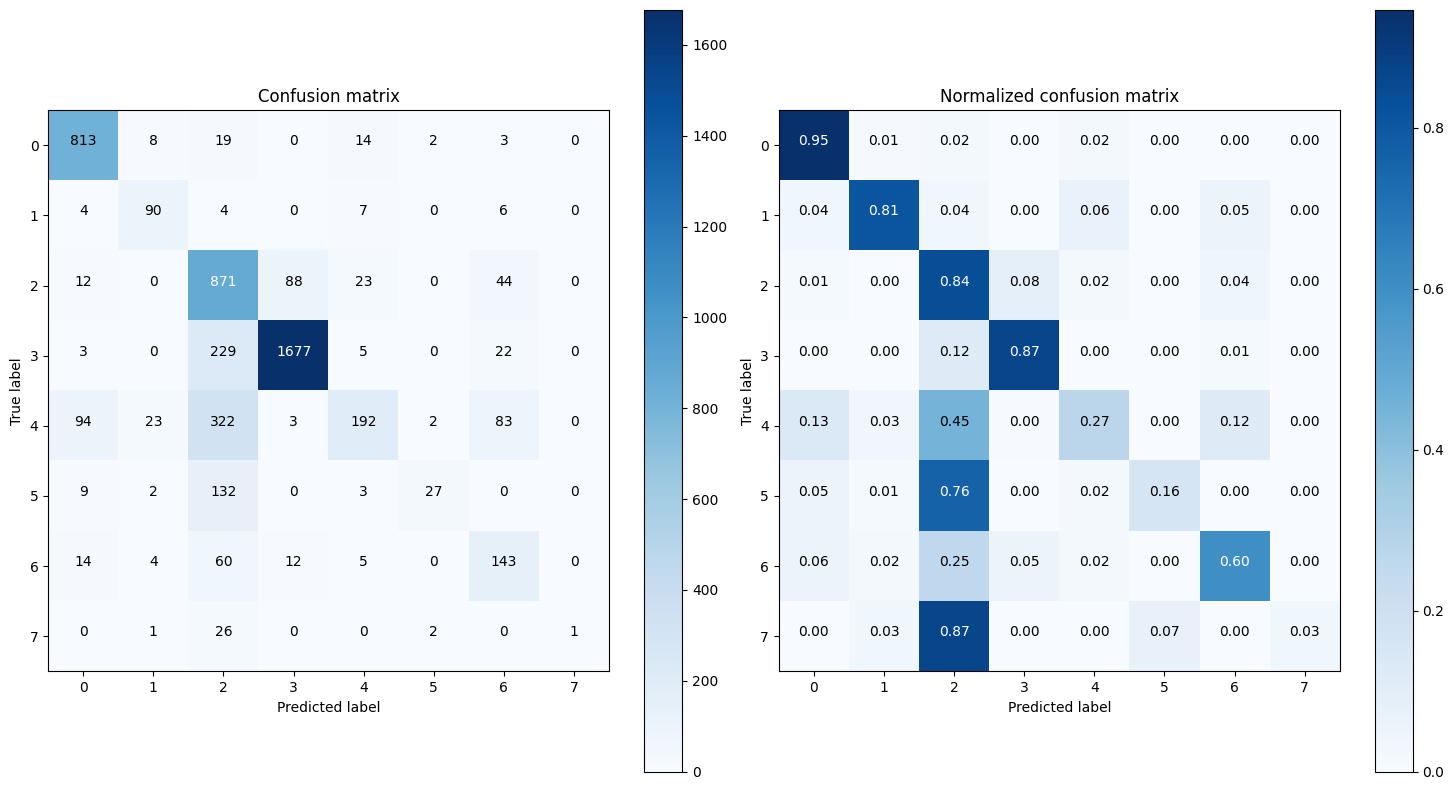

In [39]:
plt.style.use('default') 
cnf_matrix = confusion_matrix(y_test, y_test_pred)
# np.set_printoptions(precision=2)


fig = plt.figure(figsize=(15, 8)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 

## Plot non-normalized confusion matrix
plt.subplot(gs[0])
plot_confusion_matrix(cnf_matrix, title='Confusion matrix')

# Plot normalized confusion matrix
plt.subplot(gs[1])
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

plt.tight_layout()
plt.show()